<a href="https://colab.research.google.com/github/Biniyamgd/IDP/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#progress

!pip install dlib
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=0b10fcdd05cdb529d1d11493ce064a6884ce451fa94a0d29794659e0e63defc1
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [32]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.png


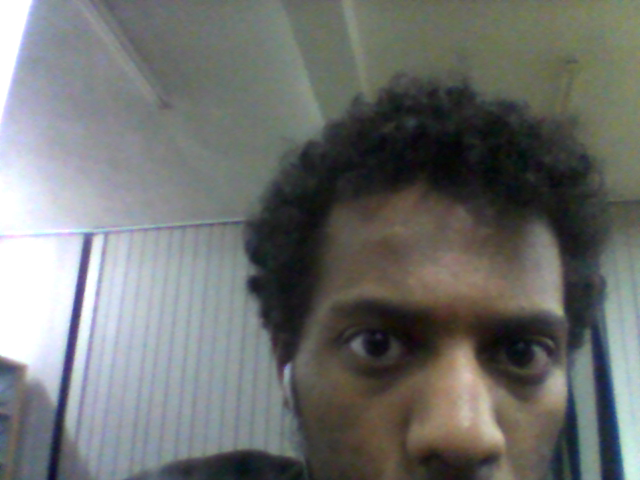

In [18]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<function matplotlib.pyplot.show(close=None, block=None)>

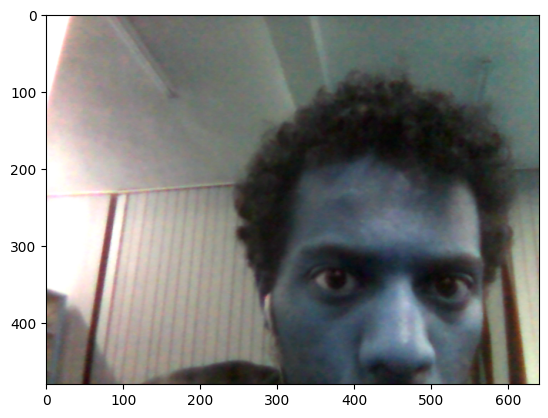

In [19]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
img= cv2.imread('./photo.png')
plt.imshow(img)
plt.show

In [41]:
import cv2
import os
import face_recognition

filepath='./'
folder=os.listdir(filepath)
modelist=[]
stuid=[]
encodeList=[]
for Path in folder:
  # if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))

print(modelist[1])


def encodingImg(Img):
  # for img in Img:
    img=cv2.cvtColor(Img,cv2.COLOR_BGR2RGB)
    encode=face_recognition.face_encodings(img)
    encodeList.append(encode)
    return encodeList

print('encoding Started...')
encodes=encodingImg(modelist[1])
print('encoding Complete...')
print(encodes)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [107 123 129]
  [107 122 131]
  [105 121 133]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [111 125 131]
  [109 124 133]
  [107 123 135]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [112 126 132]
  [110 126 133]
  [108 125 134]]

 ...

 [[ 97  73  43]
  [ 95  73  45]
  [ 91  72  45]
  ...
  [156 152 141]
  [165 163 152]
  [172 172 160]]

 [[ 98  72  42]
  [ 96  72  44]
  [ 94  73  46]
  ...
  [151 142 133]
  [157 149 142]
  [162 156 149]]

 [[ 96  70  40]
  [ 96  72  44]
  [ 94  73  46]
  ...
  [146 136 129]
  [154 143 139]
  [157 148 144]]]
encoding Started...
encoding Complete...
[[array([-0.08954607,  0.13894638,  0.06331891,  0.03146837,  0.00125514,
       -0.04501273,  0.03454411, -0.07728739,  0.19673404, -0.05410105,
        0.20135748, -0.02503587, -0.11560515, -0.14986354,  0.09823045,
        0.13070536, -0.13362436, -0.13948046, -0.17387372, -0.13766736,
       -0.04812481, -0.01614182,  0.012

In [26]:
import os
# os.mkdir('./encoding')
# os.chdir('./encoding')
!touch encodeGenerator.py

In [ ]:
# import os
# os.chdir('./encoding')
open('encodeGenerator.py')


<_io.TextIOWrapper name='encodeGenerator.py' mode='r' encoding='UTF-8'>

In [18]:
import os
import cv2
filepath='./'
folder=os.listdir(filepath)
modelist=[]
modelist.append(cv2.imread(os.path.join(filepath,'photo.jpg')))
print(modelist)


[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 97, 127, 132],
        [ 94, 123, 130],
        [ 93, 122, 129]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 97, 127, 132],
        [ 96, 125, 132],
        [ 95, 124, 131]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 96, 126, 131],
        [ 98, 126, 133],
        [ 98, 125, 135]],

       ...,

       [[218, 218, 212],
        [222, 222, 216],
        [230, 227, 222],
        ...,
        [169, 162, 145],
        [170, 161, 147],
        [175, 166, 152]],

       [[199, 198, 194],
        [208, 207, 203],
        [221, 218, 214],
        ...,
        [172, 165, 150],
        [171, 162, 149],
        [175, 163, 151]],

       [[180, 178, 177],
        [193, 191, 190],
        [210, 206, 205],
        ...,
        [173, 166, 151],
        [172, 160, 150],
        [172, 160, 150]

In [28]:
import cv2
import os
import face_recognition

filepath='./'
folder=os.listdir(filepath)
modelist=[]
stuid=[]
encodeList=[]
for Path in folder:
  # Check if the item is a file and a supported image format before adding to modelist
  if os.path.isfile(os.path.join(filepath, Path)) and Path.lower().endswith(('.png', '.jpg', '.jpeg')):
    modelist.append(cv2.imread(os.path.join(filepath,Path)))

# print(modelist)


def encodingImg(imgList): # Changed function parameter to imgList to reflect that it's processing a list
    encodeList = [] # Initialize encodeList inside the function
    for img in imgList: # Iterate over each image in the list
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        encode=face_recognition.face_encodings(img) # Use img instead of i
        encodeList.append(encode)
    return encodeList

print('encoding Started...')
encodes=encodingImg(modelist) # Pass the list of images
print('encoding Complete...')
print(encodes)

encoding Started...
encoding Complete...
[[array([-0.08954607,  0.13894638,  0.06331891,  0.03146837,  0.00125514,
       -0.04501273,  0.03454411, -0.07728739,  0.19673404, -0.05410105,
        0.20135748, -0.02503587, -0.11560515, -0.14986354,  0.09823045,
        0.13070536, -0.13362436, -0.13948046, -0.17387372, -0.13766736,
       -0.04812481, -0.01614182,  0.01289339,  0.08664258, -0.15367377,
       -0.35461894, -0.0944538 , -0.17569762,  0.15224519, -0.07782039,
       -0.00512131, -0.0243312 , -0.23573419, -0.07545314, -0.02881925,
       -0.01886001,  0.08531403, -0.03943672,  0.17402209,  0.0268434 ,
       -0.1744912 ,  0.02453202, -0.01730152,  0.23482712,  0.18129854,
       -0.03809137,  0.00285469,  0.03048429,  0.1099638 , -0.19495034,
        0.10475156,  0.05703469,  0.15744415,  0.04023482,  0.05189604,
       -0.15744874, -0.03200457,  0.0254033 , -0.25386563,  0.07573017,
        0.04934531, -0.11615246, -0.12884262, -0.00125521,  0.18390819,
        0.19866377, -

In [12]:
import cv2
import os

img1= cv2.imread('./photo.jpg')
img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
